### Data Loading

In [2]:
from feature_data_from_mat import get_high_gamma_data
import numpy as np

In [19]:
pt = 'S26'
hg_trace, hg_map, phon_labels = get_high_gamma_data(f'../data/{pt}/{pt}_HG_sigChannel_goodTrials.mat')

In [20]:
print(hg_trace.shape)
print(np.mean(hg_trace, axis=0).shape)
print(np.mean(np.mean(hg_trace, axis=0), axis=1).shape)

(148, 200, 111)
(200, 111)
(200,)


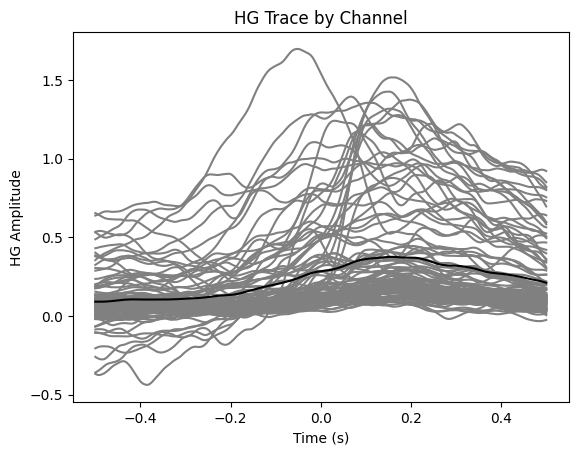

In [21]:
import matplotlib.pyplot as plt
t = np.linspace(-0.5, 0.5, hg_trace.shape[1])

plt.figure()
plt.plot(t, np.mean(hg_trace, axis=0), 'grey')
plt.plot(t, np.mean(np.mean(hg_trace, axis=0), axis=1), 'black')
# plt.ylim([-0.5, 1])
plt.title('HG Trace by Channel')
plt.ylabel('HG Amplitude')
plt.xlabel('Time (s)')
plt.show()

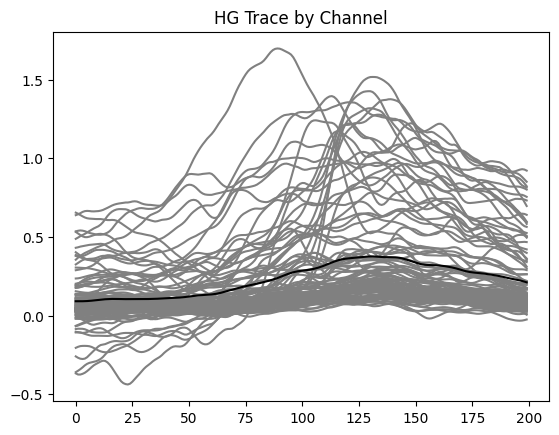

In [6]:
plt.figure()
plt.plot(np.mean(hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

### Data Preprocessing

In [6]:
from sequence_processing import pad_sequence_teacher_forcing

n_output = 10

In [7]:
X = hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
# X1 = S14_hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X_prior, y, prior_labels, seq_labels = pad_sequence_teacher_forcing(phon_labels, n_output)  # first 2 outputs one-hot encoded

### MixUp Testing

In [8]:
from sklearn.model_selection import ShuffleSplit
from data_augmentation import generate_mixup

In [9]:
data_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
train_idx, test_idx = next(data_split.split(X))
X_train, X_test = X[train_idx], X[test_idx]
X_prior_train, X_prior_test = X_prior[train_idx], X_prior[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
seq_labels_train, seq_labels_test = seq_labels[train_idx], seq_labels[test_idx]

In [10]:
alpha = 10

In [11]:
mix_X, mix_X_prior, mix_y = generate_mixup(X, X_prior, y, seq_labels)
print(f'X shape: {mix_X.shape}')
print(f'X_prior shape: {mix_X_prior.shape}')
print(f'y shape: {mix_y.shape}')

X shape: (278, 200, 111)
X_prior shape: (278, 3, 10)
y shape: (278, 3, 10)


In [12]:
mix_X_train, mix_X_prior_train, mix_y_train = generate_mixup(
                                                X_train, X_prior_train,
                                                y_train, seq_labels_train,
                                                alpha=1)
print(f'X_train shape: {mix_X_train.shape}')
print(f'X_prior_train shape: {mix_X_prior_train.shape}')
print(f'y_train shape: {mix_y_train.shape}')

mix_X_only = mix_X_train[X_train.shape[0]:,:,:]
print(f'MixUp Train Trials Added: {mix_X_only.shape[0]}')

X_train shape: (201, 200, 111)
X_prior_train shape: (201, 3, 10)
y_train shape: (201, 3, 10)
MixUp Train Trials Added: 86


In [13]:
import matplotlib.pyplot as plt

t = np.linspace(-0.5, 0.5, X_train.shape[1])

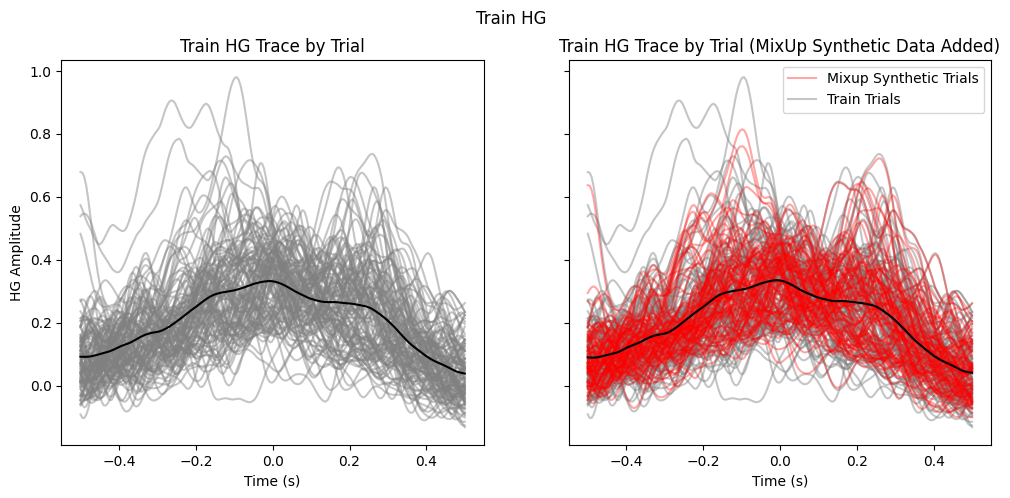

In [14]:


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax1.plot(t, np.mean(X_train, axis=-1).T, 'grey', alpha=0.45)
ax1.plot(t, np.mean(np.mean(X_train, axis=-1), axis=0), 'black')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('HG Amplitude')
ax1.set_title('Train HG Trace by Trial')

ax2.plot(t, np.mean(X_train, axis=-1).T, 'grey', alpha=0.45, label='Train Trials')
ax2.plot(t, np.mean(mix_X_only, axis=-1).T, 'red', alpha=0.35, label='Mixup Synthetic Trials')
ax2.plot(t, np.mean(np.mean(mix_X_train, axis=-1), axis=0), 'black')
ax2.set_xlabel('Time (s)')
ax2.set_title('Train HG Trace by Trial (MixUp Synthetic Data Added)')

handles, labels = ax2.get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax2.legend(handles, labels, loc='best')

plt.suptitle('Train HG')
plt.show()

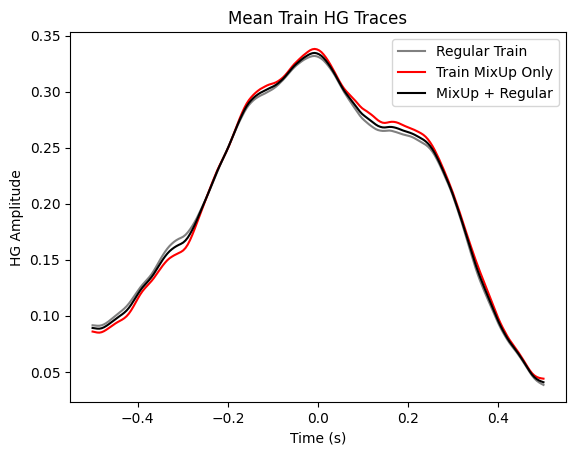

In [15]:
plt.figure()
plt.plot(t, np.mean(np.mean(X_train, axis=-1), axis=0), 'grey', label='Regular Train')
plt.plot(t, np.mean(np.mean(mix_X_only, axis=-1), axis=0), 'red', label='Train MixUp Only')
plt.plot(t, np.mean(np.mean(mix_X_train, axis=-1), axis=0), 'black', label='MixUp + Regular')
plt.xlabel('Time (s)')
plt.ylabel('HG Amplitude')
plt.title('Mean Train HG Traces')
plt.legend()
plt.show()

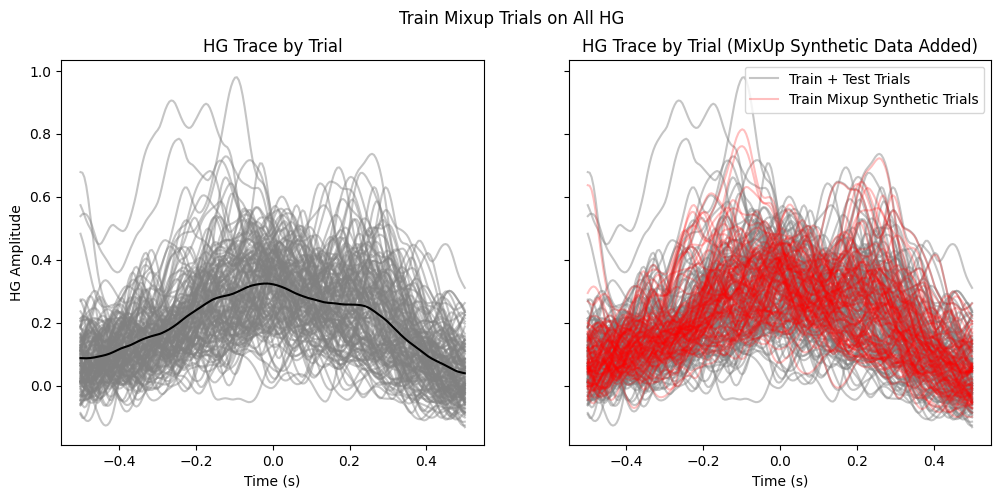

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax1.plot(t, np.mean(X, axis=-1).T, 'grey', alpha=0.45)
ax1.plot(t, np.mean(np.mean(X, axis=-1), axis=0), 'black')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('HG Amplitude')
ax1.set_title('HG Trace by Trial')

ax2.plot(t, np.mean(X, axis=-1).T, 'grey', alpha=0.45, label='Train + Test Trials')
ax2.plot(t, np.mean(mix_X_only, axis=-1).T, 'red', alpha=0.25, label='Train Mixup Synthetic Trials')
ax2.set_xlabel('Time (s)')
ax2.set_title('HG Trace by Trial (MixUp Synthetic Data Added)')

handles, labels = ax2.get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax2.legend(handles, labels, loc='best')

plt.suptitle('Train Mixup Trials on All HG')
plt.show()

### Jitter Testing

#### Extended Data Loading

In [17]:
pt = 'S14'
hg_trace_ext, hg_map_ext, phon_labels = get_high_gamma_data(f'../data/{pt}/{pt}_HG_sigChannel_extended_goodTrials.mat')
X_ext = hg_trace_ext  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN

In [18]:
print(hg_trace_ext.shape)
print(np.mean(hg_trace_ext, axis=0).shape)
print(np.mean(np.mean(hg_trace_ext, axis=0), axis=1).shape)

(144, 400, 111)
(400, 111)
(400,)


#### Jitter Regular Data

In [19]:
from sklearn.model_selection import ShuffleSplit
from data_augmentation import generate_time_jitter

In [20]:
fs = 200

In [21]:
X_ext_train, X_ext_test = X_ext[train_idx], X_ext[test_idx]

In [38]:
j_end = 0.5
# define jitter by number of points
n_jitter = 8
if n_jitter % 2 == 0:
    n_jitter += 1  # +1 to include 0
jitter_vals = np.linspace(-j_end, j_end, n_jitter)  

# define jitter by step size
# j_step = 0.25
# jitter_vals = np.arange(-j_end, j_end+j_step, j_step)

print(jitter_vals)

[-0.5   -0.375 -0.25  -0.125  0.     0.125  0.25   0.375  0.5  ]


In [40]:
jitter_X, jitter_X_prior, jitter_y = generate_time_jitter(X_ext, X_prior, y, jitter_vals, 1, fs)
print(f'Jitter X shape: {jitter_X.shape}')
print(f'Jitter X_prior shape: {jitter_X_prior.shape}')
print(f'Jitter y shape: {jitter_y.shape}')

Jitter X shape: (1296, 200, 111)
Jitter X_prior shape: (1296, 3, 10)
Jitter y shape: (1296, 3, 10)


In [41]:
jitter_X_train, jitter_X_prior_train, jitter_y_train = generate_time_jitter(X_ext_train, X_prior_train, y_train, jitter_vals, 1, fs)
print(f'Jitter X_train shape: {jitter_X_train.shape}')
print(f'Jitter X_prior_train shape: {jitter_X_prior_train.shape}')
print(f'Jitter y_train shape: {jitter_y_train.shape}')

Jitter X_train shape: (1035, 200, 111)
Jitter X_prior_train shape: (1035, 3, 10)
Jitter y_train shape: (1035, 3, 10)


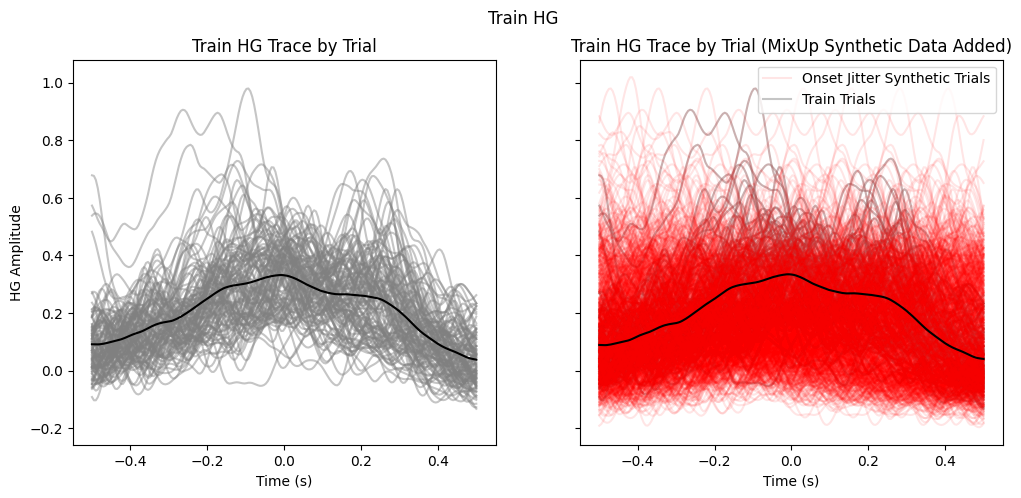

In [42]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax1.plot(t, np.mean(X_train, axis=-1).T, 'grey', alpha=0.45)
ax1.plot(t, np.mean(np.mean(X_train, axis=-1), axis=0), 'black')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('HG Amplitude')
ax1.set_title('Train HG Trace by Trial')

ax2.plot(t, np.mean(X_train, axis=-1).T, 'grey', alpha=0.45, label='Train Trials')
ax2.plot(t, np.mean(jitter_X_train, axis=-1).T, 'red', alpha=0.1, label='Onset Jitter Synthetic Trials')
ax2.plot(t, np.mean(np.mean(mix_X_train, axis=-1), axis=0), 'black')
ax2.set_xlabel('Time (s)')
ax2.set_title('Train HG Trace by Trial (MixUp Synthetic Data Added)')

handles, labels = ax2.get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax2.legend(handles, labels, loc='best')

plt.suptitle('Train HG')
plt.show()

#### Jitter MixUp Data (MixUp then Jitter)

In [43]:
mix_X_ext_train, mix_X_prior_train, mix_y_train = generate_mixup(X_ext_train, X_prior_train, y_train, seq_labels_train)
print(f'MixUp Train Extended X shape: {mix_X_ext_train.shape}')
print(f'MixUp TrainX_prior shape: {mix_X_prior_train.shape}')
print(f'MixUp Train y shape: {mix_y_train.shape}')

MixUp Train Extended X shape: (201, 400, 111)
MixUp TrainX_prior shape: (201, 3, 10)
MixUp Train y shape: (201, 3, 10)


In [44]:
jitter_mix_X_train, jitter_mix_X_prior_train, jitter_mix_y_train = generate_time_jitter(mix_X_ext_train, mix_X_prior_train, mix_y_train, jitter_vals, 1, fs)
print(f'Jitter + MixUp X_train shape: {jitter_mix_X_train.shape}')
print(f'Jitter + MixUp X_prior_train shape: {jitter_mix_X_prior_train.shape}')
print(f'Jitter + MixUp y_train shape: {jitter_mix_y_train.shape}')

Jitter + MixUp X_train shape: (1809, 200, 111)
Jitter + MixUp X_prior_train shape: (1809, 3, 10)
Jitter + MixUp y_train shape: (1809, 3, 10)
